In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2


Bad key "hatch.linewidth" on line 54 in
/home/gpleiss/.dotfiles/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
from torch.autograd import Variable
train_x = Variable(torch.linspace(0, 0.75, 11))
train_y = Variable(torch.sin(train_x.data * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2)

In [3]:
from torch import optim
from gpytorch.kernels import RBFKernel, SpectralMixtureKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.random_variables import GaussianRandomVariable

In [4]:
class SpectralMixtureGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(SpectralMixtureGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean(constant_bounds=(-1, 1))
        self.covar_module = SpectralMixtureKernel(n_mixtures=3)

    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return GaussianRandomVariable(mean_x, covar_x)

likelihood = GaussianLikelihood(log_noise_bounds=(-5, 5))
model = SpectralMixtureGPModel(train_x.data, train_y.data, likelihood)

In [5]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

optimizer = optim.Adam(list(model.parameters()) + list(likelihood.parameters()), lr=0.1)
optimizer.n_iter = 0
for i in range(50):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -model.marginal_log_likelihood(likelihood, output, train_y)
    loss.backward()
    optimizer.n_iter += 1
    print('Iter %d/50 - Loss: %.3f' % (i + 1, loss.data[0]))
    optimizer.step()

Iter 1/50 - Loss: 1.519
Iter 2/50 - Loss: 1.338
Iter 3/50 - Loss: 1.343
Iter 4/50 - Loss: 1.224
Iter 5/50 - Loss: 1.047
Iter 6/50 - Loss: 0.850
Iter 7/50 - Loss: 0.903
Iter 8/50 - Loss: 0.802
Iter 9/50 - Loss: 0.662
Iter 10/50 - Loss: 0.744
Iter 11/50 - Loss: 0.518
Iter 12/50 - Loss: 0.640
Iter 13/50 - Loss: 0.432
Iter 14/50 - Loss: 0.356
Iter 15/50 - Loss: 0.491
Iter 16/50 - Loss: 0.300
Iter 17/50 - Loss: 0.465
Iter 18/50 - Loss: 0.234
Iter 19/50 - Loss: 0.095
Iter 20/50 - Loss: 0.104
Iter 21/50 - Loss: 0.171
Iter 22/50 - Loss: 0.271
Iter 23/50 - Loss: 0.202
Iter 24/50 - Loss: -0.125
Iter 25/50 - Loss: -0.131
Iter 26/50 - Loss: 0.332
Iter 27/50 - Loss: 0.239
Iter 28/50 - Loss: 0.016
Iter 29/50 - Loss: 0.223
Iter 30/50 - Loss: 0.035
Iter 31/50 - Loss: -0.058
Iter 32/50 - Loss: -0.447
Iter 33/50 - Loss: -0.063
Iter 34/50 - Loss: 0.106
Iter 35/50 - Loss: -0.246
Iter 36/50 - Loss: -0.069
Iter 37/50 - Loss: 0.054
Iter 38/50 - Loss: -0.159
Iter 39/50 - Loss: -0.196
Iter 40/50 - Loss: -0.131

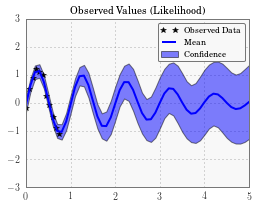

In [6]:
model.eval()
likelihood.eval()

f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
test_x = Variable(torch.linspace(0, 5, 51))
observed_pred = likelihood(model(test_x))

def ax_plot(ax, rand_var, title):
    lower, upper = rand_var.confidence_region()
    ax.plot(train_x.data.numpy(), train_y.data.numpy(), 'k*')
    ax.plot(test_x.data.numpy(), rand_var.mean().data.numpy(), 'b')
    ax.fill_between(test_x.data.numpy(), lower.data.numpy(), upper.data.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title(title)

ax_plot(observed_ax, observed_pred, 'Observed Values (Likelihood)')